In [46]:
import struct
from array import array
from os import path
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from tqdm import tqdm
from torchvision.transforms import v2

In [47]:
#скачание датасета

# train_dataset = torchvision.datasets.MNIST(root="c:/users/abobantai/Desktop/IT/pytorchl", train=True, download=True)
# test_dataset = torchvision.datasets.MNIST(root="c:/users/abobantai/Desktop/IT/pytorchl", train=False, download=True)

In [48]:
#распаковка датасета

# def read(dataset):
#     if dataset is "training":
#         path_img = "c:/users/abobantai/Desktop/IT/pytorchl/MNIST/raw/train-images-idx3-ubyte"
#         path_lbl = "c:/users/abobantai/Desktop/IT/pytorchl/MNIST/raw/train-labels-idx1-ubyte"
#     elif dataset is "testing":
#         path_img = "c:/users/abobantai/Desktop/IT/pytorchl/MNIST/raw/t10k-images-idx3-ubyte"
#         path_lbl = "c:/users/abobantai/Desktop/IT/pytorchl/MNIST/raw/t10k-labels-idx1-ubyte"
#     else:
#         raise ValueError("dataset must be \"training\" or \"testing\"")
#     with open(path_lbl, "rb") as f_label:
#         _, size = struct.unpack(">II", f_label.read(8))
#         lbl = array("b", f_label.read())
#     with open(path_img, "rb") as f_img:
#         _, size, rows, cols = struct.unpack(">IIII", f_img.read(16))
#         img = array("b", f_img.read())
#     return lbl, img, size, rows, cols
# def write_dataset(labels, data, size, rows, cols, output_dir):
#     classes = {i :f"class{i}" for i in range(10)}
#     output_dirs = [
#         path.join(output_dir, classes[i])
#         for i in range(10)
#     ]
#     for dir in output_dirs:
#         if not path.exists(dir):
#             os.makedirs(dir)
#     for (i, label) in enumerate(labels):
#         output_filename = path.join(output_dirs[label], str(i) + ".png")
#         print("writing " + output_filename)
#         with open(output_filename, "wb") as h:
#             data_i = [
#                 data[ (i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols) ]
#                 for j in range(rows)
#             ]
#             data_array = np.asarray(data_i)
#             im = Image.fromarray(data_array)
#             im.save(output_filename)
# output_path = "c:/users/abobantai/Desktop/IT/pytorchl/mnist"
# for dataset in ["training", "testing"]:
#     write_dataset(*read(dataset), path.join(output_path, dataset))

In [49]:
# определение процессора для обучения

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [50]:
#все необходимые трансформаций для MNIST

transforms = v2.Compose([
    v2.ToTensor(),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=([0.5]), std=([0.5]))
])

In [51]:

train_data = ImageFolder(root="mnist/training",transform=transforms)
test_data = ImageFolder(root="mnist/testing",transform=transforms)

In [52]:
train_data, val_data = random_split(train_data, [0.8, 0.2])

In [53]:
train_data = DataLoader(train_data, batch_size=64, shuffle=True)
val_data = DataLoader(val_data, batch_size=64, shuffle=False)
test_data = DataLoader(test_data, batch_size=64, shuffle=False)

In [54]:
# создание модели с помощью nn.Sequential()


# model = nn.Sequential(
#     nn.Linear(784,198),
#     nn.ReLU(),
#     nn.Linear(196,49),
#     nn.LeakyReLU(),
#     nn.Linear(49,10),
#     nn.Softmax()
# ).to(device)


In [55]:
# создание модели с помощью nn.Sequential(), и добавление слои с именами


# model = nn.Sequential()
# model.add_module('lineat_layer1', nn.Linear(784, 392))
# model.add_module('relu1', nn.ReLU())
# model.add_module('linear_layer2', nn.Linear(392, 98))
# model.add_module('sigmoid2', nn.Sigmoid())
# model.add_module('linear_layer3', nn.Linear(98, 10))
# model.add_module('softmax3', nn.Softmax())
# model.to(device)


In [56]:
# создание модели с помощью класса nn.Module
#        ###
#       ####
#      #####
#     ######
#        ###
#        ###
#        ###
#        ###
#       #####
#       #####
# архитектура
# class myModel(nn.Module):
#     def __init__(self, input, output): # определение класа
#         super().__init__()
#         self.layer1 = nn.Linear(input, 512) # первый слои вход=784 выход=512
#         self.layer2 = nn.Linear(512, 128)# второй слои вход=512 выход=128
#         self.layer3 = nn.Linear(128, output)# второй слои вход=128 выход=10
#         self.relu = nn.ReLU() # функция активация relu
#     def forward(self, x):
#         x = self.layer1(x) # подача данных в первый слои и запись выхода в переменную х
#         x = self.layer2(x) # подача данных с первого слоя на в второй слои и запись выхода в переменную х
#         x = self.relu(x) # подача данных со второгого слоя на функция активация и запись выхода в переменную х
#         x = self.layer3(x)
#         return x # возврацение вычислений модели
# model = myModel(784, 10).to(device) # определение модели

1-архиектура:

**гиперпараметры:**
|ТИП|ЗНАЧЕНИЕ|
|-|-|
|эпохи|50|
|оптимизатор|adam|
|вычисление ошибки|CrossEntropyLoss|
|батчи|64|
---




In [57]:
# # создание модели с помощью класса nn.Module
# # 2 model


# 0.9659633757961783 acc test
# 0.12294392522127506 loss test


# class myModel(nn.Module):
#     def __init__(self, input, output):
#         super().__init__()
#         self.layer1 = nn.Linear(input, 2048) 
#         self.layer2 = nn.Linear(2048, 512)
#         self.layer3 = nn.Linear(512, 128)
#         self.relu = nn.ReLU()
#         self.layer4 = nn.Linear(128, output)
#         self.dropout = nn.Dropout(0.3)
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.dropout(x)
#         x = self.layer2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.layer3(x)
#         x = self.dropout(x)
#         x = self.layer4(x)
#         x = self.relu(x)
#         return x 
# model = myModel(784, 10).to(device) 

In [ ]:
# MODEL3



# 0.9874601910828026 TEST ACC
# 0.02679583193418663 TEST LOSS






# class MyModel(nn.Module):
#     def __init__(self, in_channel, output):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 32, 3, bias=True),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Conv2d(32, 64, 3, bias=True),
#             nn.Dropout(0.5)
#         )
#         self.flat = nn.Flatten()
#         self.fc = nn.Sequential(
#             nn.Linear(576*64, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 10)
#         )
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.flat(x)
#         x = self.fc(x)
#         return x
# model = MyModel(1, 10).to(device=device)

In [59]:
# настроика оптимизатора, вычисления ошибки и шедулера

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [60]:
#создания списка для анализа обучения моделиfnfno

train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []

In [61]:
#цикл обучения модели

epochs = 50 #эпохи
best_loss = None
count = 0

for epoch in range(epochs):
    count += 1
    lr = scheduler._last_lr  # текущяя скорость обучения
    train_loop = tqdm(train_data, leave=False)  # определение прогрес бара
    true_answer = 0 # счет правильных ответов за каждую эпоху не включая данных валидаций
    runnig_train_loss = [] # список ошибок тренировки каждой эпохи
    model.train()
    for x, tpred in train_loop: # перебор всех батчей тренировочных данных
        x = x.to(device) # преоброзавание данных для модели
        tpred = tpred.reshape(-1).to(torch.int32) # преоброзавание данных для модели
        tpred = torch.eye(10)[tpred].to(device) # преоброзавание правильных ответов на ванхотвектора

        pred = model(x) # подача изображения в модель
        los = loss(pred, tpred) # вычисление ошибки

        optimizer.zero_grad() # обнуление градиентов 
        los.backward() # обратное распростронение
        optimizer.step() # обновление

        runnig_train_loss.append(los.item()) # добавление значений ошибок в список
        mean_train_loss = sum(runnig_train_loss) / len(runnig_train_loss) # вычисление среднего значения ошибок

        true_answer += (pred.argmax(dim=1) == tpred.argmax(dim=1)).sum().item() # счетчик правильных предсказаний

        train_loop.set_description(f"epoch [{epoch+1}], train_loss = {mean_train_loss:.4f}") 
    runnig_train_acc = true_answer/64 / len(train_data) # вычисление точность предсказаний модели

    train_loss.append(mean_train_loss) # добавления среднего значения ошибок модели в список для анализа
    train_acc.append(runnig_train_acc) # добавления среднего значения точности предсказаний моделя в список для анализа


    model.eval()
    with torch.no_grad(): # режим отключения вычисления градиентов
        runnig_val_loss = [] # список ошибок моделя в валидаций
        true_answer = 0 # счет правильных ответов в валидаций
        for x, tpred in val_data:
            x = x.to(device)
            tpred = tpred.reshape(-1).to(torch.int32)
            tpred = torch.eye(10)[tpred].to(device)

            pred = model(x)
            los = loss(pred, tpred)

            runnig_val_loss.append(los.item()) 
            mean_val_loss = sum(runnig_val_loss) / len(runnig_val_loss)
            true_answer += (pred.argmax(dim=1) == tpred.argmax(dim=1)).sum().item()
        runnig_val_acc = true_answer/64 / len(val_data)
        val_loss.append(mean_val_loss)
        val_acc.append(runnig_val_acc)
    #                                       |
    # вывод результата обучения одной эпохи\|/
    #                                       '
    print(f"epoch [{epoch+1}/{epochs}], train_loss = {mean_train_loss:.4f}, train_acc = {runnig_train_acc:.4f}, val_loss = {mean_val_loss:.4f}, val_acc = {runnig_val_acc:.4f}, lr = {lr}")
    scheduler.step(mean_val_loss) #обновление шедулера
    lr_list.append(lr) # добавления значения скорости обучения в список

    if best_loss == None:
        best_loss = mean_val_loss
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        count = 0
        checkpoint = {
            "state_model": model.state_dict(),
            "state_optimizer": optimizer.state_dict(),
            "state_scheduler": scheduler.state_dict(),
            "loss": {
                "train_loss": train_loss,
                "val_loss": val_loss,
                "best_loss": best_loss
            },
            "metric":{
                "train_accuracy": train_acc,
                "val_accuracy": val_acc
            },
            "lr": lr_list,
            "epoch": {
                "epochs": epochs,
                "save_epochs": epoch
            }
        }
        torch.save(checkpoint, f'checkpoints/model_state_dict_epoch_{epoch+1}.pt')
        print(f"checkpoint on epoch {epoch+1} with best val metrics: {mean_val_loss:.6f}")
    if count >  10:
        print(f"мертвая точка, конец обучения в эпохе-{epoch+1}")
        break

epoch [1/50], train_loss = 0.3097, train_acc = 0.9088, val_loss = 0.1035, val_acc = 0.9674, lr = [0.0001]


epoch [2/50], train_loss = 0.1036, train_acc = 0.9683, val_loss = 0.0646, val_acc = 0.9794, lr = [0.0001]
checkpoint on epoch 2 with best val metrics: 0.064624


epoch [3/50], train_loss = 0.0733, train_acc = 0.9769, val_loss = 0.0565, val_acc = 0.9806, lr = [0.0001]
checkpoint on epoch 3 with best val metrics: 0.056531


epoch [4/50], train_loss = 0.0616, train_acc = 0.9801, val_loss = 0.0475, val_acc = 0.9829, lr = [0.0001]
checkpoint on epoch 4 with best val metrics: 0.047516


epoch [5/50], train_loss = 0.0517, train_acc = 0.9832, val_loss = 0.0426, val_acc = 0.9847, lr = [0.0001]
checkpoint on epoch 5 with best val metrics: 0.042628


epoch [6/50], train_loss = 0.0447, train_acc = 0.9855, val_loss = 0.0421, val_acc = 0.9857, lr = [0.0001]
checkpoint on epoch 6 with best val metrics: 0.042122


epoch [7/50], train_loss = 0.0414, train_acc = 0.9865, val_loss = 0.0430, val_acc = 0.9840, lr = [0.0001]


epoch [8/50], train_loss = 0.0371, train_acc = 0.9879, val_loss = 0.0409, val_acc = 0.9859, lr = [0.0001]
checkpoint on epoch 8 with best val metrics: 0.040927


epoch [9/50], train_loss = 0.0318, train_acc = 0.9894, val_loss = 0.0424, val_acc = 0.9853, lr = [0.0001]


epoch [10/50], train_loss = 0.0299, train_acc = 0.9902, val_loss = 0.0424, val_acc = 0.9852, lr = [0.0001]


epoch [11/50], train_loss = 0.0260, train_acc = 0.9915, val_loss = 0.0432, val_acc = 0.9861, lr = [0.0001]


epoch [12/50], train_loss = 0.0259, train_acc = 0.9913, val_loss = 0.0394, val_acc = 0.9866, lr = [0.0001]
checkpoint on epoch 12 with best val metrics: 0.039450


epoch [13/50], train_loss = 0.0246, train_acc = 0.9922, val_loss = 0.0396, val_acc = 0.9872, lr = [0.0001]


epoch [14/50], train_loss = 0.0208, train_acc = 0.9935, val_loss = 0.0406, val_acc = 0.9871, lr = [0.0001]


epoch [15/50], train_loss = 0.0200, train_acc = 0.9933, val_loss = 0.0423, val_acc = 0.9863, lr = [0.0001]


epoch [16/50], train_loss = 0.0191, train_acc = 0.9937, val_loss = 0.0405, val_acc = 0.9873, lr = [0.0001]


epoch [17/50], train_loss = 0.0189, train_acc = 0.9934, val_loss = 0.0402, val_acc = 0.9879, lr = [0.0001]


epoch [18/50], train_loss = 0.0175, train_acc = 0.9942, val_loss = 0.0396, val_acc = 0.9870, lr = [0.0001]


epoch [19/50], train_loss = 0.0130, train_acc = 0.9958, val_loss = 0.0371, val_acc = 0.9875, lr = [1e-05]
checkpoint on epoch 19 with best val metrics: 0.037066


epoch [20/50], train_loss = 0.0123, train_acc = 0.9960, val_loss = 0.0364, val_acc = 0.9877, lr = [1e-05]
checkpoint on epoch 20 with best val metrics: 0.036424


epoch [21/50], train_loss = 0.0108, train_acc = 0.9966, val_loss = 0.0360, val_acc = 0.9879, lr = [1e-05]
checkpoint on epoch 21 with best val metrics: 0.035973


epoch [22/50], train_loss = 0.0090, train_acc = 0.9973, val_loss = 0.0366, val_acc = 0.9880, lr = [1e-05]


epoch [23/50], train_loss = 0.0095, train_acc = 0.9969, val_loss = 0.0365, val_acc = 0.9881, lr = [1e-05]


epoch [24/50], train_loss = 0.0089, train_acc = 0.9972, val_loss = 0.0363, val_acc = 0.9880, lr = [1e-05]


epoch [25/50], train_loss = 0.0087, train_acc = 0.9972, val_loss = 0.0364, val_acc = 0.9884, lr = [1e-05]


epoch [26/50], train_loss = 0.0089, train_acc = 0.9970, val_loss = 0.0371, val_acc = 0.9880, lr = [1e-05]


epoch [27/50], train_loss = 0.0084, train_acc = 0.9972, val_loss = 0.0372, val_acc = 0.9883, lr = [1e-05]


epoch [28/50], train_loss = 0.0077, train_acc = 0.9974, val_loss = 0.0372, val_acc = 0.9883, lr = [1.0000000000000002e-06]


epoch [29/50], train_loss = 0.0084, train_acc = 0.9971, val_loss = 0.0373, val_acc = 0.9881, lr = [1.0000000000000002e-06]


epoch [30/50], train_loss = 0.0072, train_acc = 0.9977, val_loss = 0.0373, val_acc = 0.9883, lr = [1.0000000000000002e-06]


epoch [31/50], train_loss = 0.0068, train_acc = 0.9976, val_loss = 0.0373, val_acc = 0.9884, lr = [1.0000000000000002e-06]


epoch [32/50], train_loss = 0.0077, train_acc = 0.9976, val_loss = 0.0372, val_acc = 0.9883, lr = [1.0000000000000002e-06]
мертвая точка, конец обучения в эпохе-32


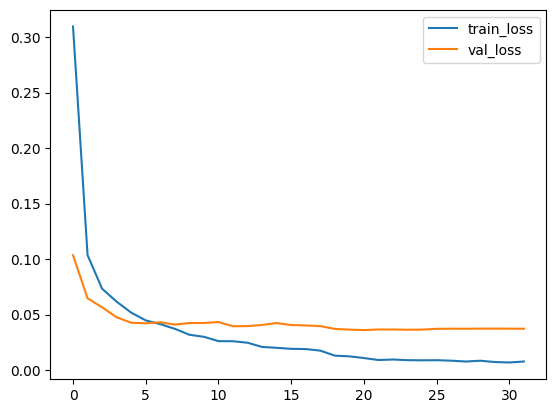

In [62]:
#график ошибки моделя при тренировки и валидаций

plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss','val_loss'])
plt.show()

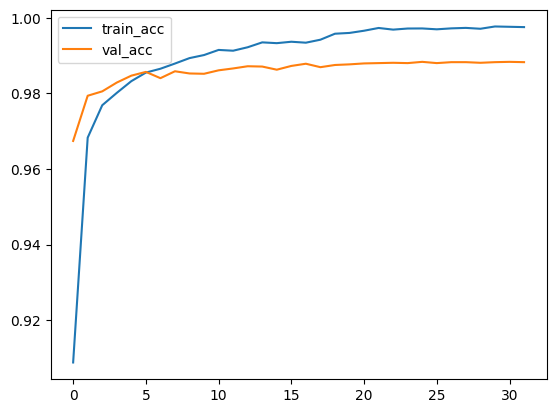

In [63]:
#график точности моделя при тренировке и валидаций

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc','val_acc'])
plt.show()

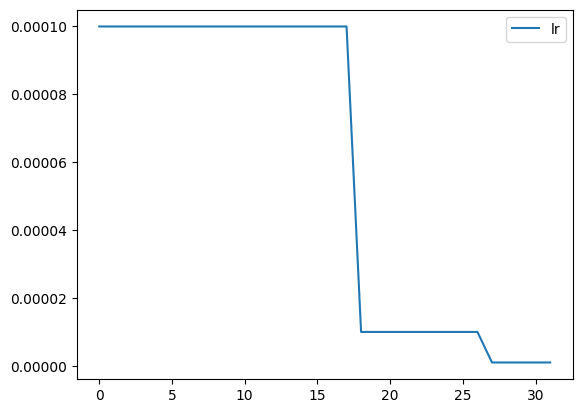

In [64]:
#график изменений скорости обучения

plt.plot(lr_list)
plt.legend(['lr'])
plt.show()

In [65]:
#сохранение модели
#
#для каждой архитектуры бдует создана новый каталог в каталоге models

torch.save(model.state_dict(), 'models/model3/model3.pt')

In [66]:
# model_dict = torch.load('models/model1/model1.pt')
# model.load_state_dict(model_dict)



In [67]:
with torch.no_grad(): # режим отключения вычисления градиентов
        runnig_test_loss = [] # список ошибок моделя в тесте
        true_answer = 0 # счет правильных предсказаний в тесте
        for x, tpred in test_data:
            x = x.to(device)
            tpred = tpred.reshape(-1).to(torch.int32)
            tpred = torch.eye(10)[tpred].to(device)

            pred = model(x)
            los = loss(pred, tpred)

            runnig_test_loss.append(los.item()) 
            mean_test_loss = sum(runnig_test_loss) / len(runnig_test_loss)
            true_answer += (pred.argmax(dim=1) == tpred.argmax(dim=1)).sum().item()
        runnig_test_acc = true_answer/64 / len(test_data)
print(runnig_test_acc)
print(mean_test_loss)

0.9874601910828026
0.02679583193418663
